In [1]:
%matplotlib inline

import datacube
import xarray as xr
import matplotlib.pyplot as plt

# import sys
# sys.path.insert(1, '../Tools/')
# from dea_tools.datahandling import pan_sharpen_brovey
# from dea_tools.plotting import rgb


### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [2]:
dc = datacube.Datacube(app='Pan_sharpening')


In [138]:
query = {'product': 'ga_ls8c_ard_3',
 'x': (149.11, 149.14),
 'y': (-35.31, -35.29),
 'time': '2018',
 'cloud_cover': [0, 1]}


# Native CRS
md = dc.find_datasets(**query)[0].metadata_doc
output_crs = md['crs']

# For reference, load the same image at 30 m resolution
rgbp_15m = dc.load(measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_panchromatic'],
                  resolution=(-15, 15),
                  align=(7.5, 7.5),
                  output_crs=output_crs,
                  resampling='bilinear',
                  **query)

# For reference, load the same image at 30 m resolution
rgb_30m = dc.load(measurements=['nbart_red', 'nbart_green', 'nbart_blue'],
                  resolution=(-30, 30),
                  align=(15, 15),
                  output_crs=output_crs,
                  **query)

In [139]:
import numpy as np
import skimage.transform
import sklearn.decomposition
from skimage.exposure import match_histograms


def pansharpen_pca(
    ds, pan_band="nbart_panchromatic", return_pan=False, output_dtype=None
):

    """
    Apply pan-sharpening to multispectral satellite data with one
    or more timesteps using the Principal Components Analysis
    pan-sharpening method.

    Parameters
    ----------
    ds : xarray.Dataset
        An xarrray dataset containing the three input multispectral
        bands, and a panchromatic band. This dataset should have
        already been resampled to the spatial resolution of the
        panchromatic band (15 m for Landsat).
    pan_band : string, optional
        The name of the panchromatic band that will be used to
        pan-sharpen the multispectal data.
    return_pan : bool, optional
        Whether to return the panchromatic band in the output dataset.
        Defaults to False.
    output_dtype : string or numpy.dtype, optional
        The dtype used for the output values. Defaults to the input
        dtype of the multispectral bands in `ds`.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        An xarrray dataset containing the three pan-sharped input
        multispectral bands, and (optionally) the panchromatic band.
    """

    def _pca_timestep(ds_i, pan_band):

        # Reshape to 2D by stacking x and y dimensions to
        # prepare it as an input to PCA
        da_2d = ds_i.to_array().stack(pixel=("y", "x")).transpose("pixel", "variable")

        # Create new dataarrays with and without pan band
        da_2d_nopan = da_2d.drop(pan_band, dim="variable")
        da_2d_pan = da_2d.sel(variable=pan_band)

        # Apply PCA transformation
        pca = sklearn.decomposition.PCA()
        pca_array = pca.fit_transform(da_2d_nopan)

        # Match histogram to pan band and apply reverse PCA transform to restore RGBx
        pca_array[:, 0] = match_histograms(da_2d_pan.values, pca_array[:, 0])
        pansharped_array = pca.inverse_transform(pca_array)

        # Add back into original array, reshape and return dataframe
        da_2d_nopan[:] = pansharped_array
        ds_pansharpened = da_2d_nopan.unstack("pixel").to_dataset("variable")

        return ds_pansharpened

    # Apply PCA pansharpening to all timesteps in data
    if "time" in ds.dims:
        ds_pansharpened = ds.groupby("time").apply(_pca_timestep, pan_band=pan_band)
    else:
        ds_pansharpened = _pca_timestep(ds, pan_band=pan_band)

    # Optionally insert pan band into dataset
    if return_pan:
        ds_pansharpened[pan_band] = ds[pan_band]

    return ds_pansharpened.astype(
        ds.to_array().dtype if output_dtype is None else output_dtype
    )


def pansharpen_brovey(
    ds,
    pan_band="nbart_panchromatic",
    return_pan=False,
    output_dtype=None,
    histogram_match=True,
):
    """
    Apply pan-sharpening to multispectral satellite data with one
    or more timesteps using the Brovey pan-sharpening method.

    Parameters
    ----------
    ds : xarray.Dataset
        An xarrray dataset containing the three input multispectral
        bands, and a panchromatic band. This dataset should have
        already been resampled to the spatial resolution of the
        panchromatic band (15 m for Landsat).
    pan_band : string, optional
        The name of the panchromatic band that will be used to
        pan-sharpen the multispectal data.
    return_pan : bool, optional
        Whether to return the panchromatic band in the output dataset.
        Defaults to False.
    output_dtype : string or numpy.dtype, optional
        The dtype used for the output values. Defaults to the input
        dtype of the multispectral bands in `ds`.
    histogram_match : bool, optional
        Whether to use histogram matching to return values that
        approximately match the range of values in `ds`. Defaults to
        True.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        An xarrray dataset containing the three pan-sharped input
        multispectral bands, and (optionally) the panchromatic band.
    """

    # Create new dataarrays with and without pan band
    da_nopan = ds.drop(pan_band).to_array()
    da_pan = ds[pan_band]

    # Calculate total
    da_total = da_nopan.sum(dim="variable")

    # Perform Brovey Transform in form of: band / total * panchromatic
    da_pansharpened = da_nopan / da_total * da_pan

    if histogram_match:

        if "time" in da_pansharpened.dims:

            # For each timestep, match histograms of our pansharped data
            # to the input multispectral data. We need to place our bands
            # into the final axis position via transpose so that histogram
            # matching is applied correctly across our individual bands.
            da_pansharpened = xr.concat(
                [
                    xr.apply_ufunc(
                        match_histograms,
                        da.transpose(..., "variable"),
                        da_nopan.sel(time=time).transpose(..., "variable"),
                        kwargs={"multichannel": True},
                    )
                    for time, da in da_pansharpened.groupby("time")
                ],
                dim="time",
            )

        else:

            da_pansharpened = xr.apply_ufunc(
                match_histograms,
                da_pansharpened.transpose(..., "variable"),
                da_nopan.transpose(..., "variable"),
                kwargs={"multichannel": True},
            )

    # Convert to dataset
    ds_pansharpened = da_pansharpened.to_dataset(dim="variable").reindex_like(ds)

    # Optionally insert pan band into dataset
    if return_pan:
        ds_pansharpened[pan_band] = da_pan

    # Ensure CRS is correctly assigned
    from datacube.utils.geometry import assign_crs
    ds_pansharpened = assign_crs(ds_pansharpened, ds.crs)
    
    # Modify dtype as required
    return ds_pansharpened.astype(
        da_nopan.dtype if output_dtype is None else output_dtype
    )


def pansharpen_hsv(
    ds, pan_band="nbart_panchromatic", return_pan=False, output_dtype=None
):

    """
    Apply pan-sharpening to multispectral satellite data with one
    or more timesteps using the Principal Components Analysis
    pan-sharpening method.

    Parameters
    ----------
    ds : xarray.Dataset
        An xarrray dataset containing the three input multispectral
        bands, and a panchromatic band. This dataset should have
        already been resampled to the spatial resolution of the
        panchromatic band (15 m for Landsat).
    pan_band : string, optional
        The name of the panchromatic band that will be used to
        pan-sharpen the multispectal data.
    return_pan : bool, optional
        Whether to return the panchromatic band in the output dataset.
        Defaults to False.
    output_dtype : string or numpy.dtype, optional
        The dtype used for the output values. Defaults to the input
        dtype of the multispectral bands in `ds`.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        An xarrray dataset containing the three pan-sharped input
        multispectral bands, and (optionally) the panchromatic band.
    """

    def _hsv_timestep(ds_i, pan_band):

        # Reshape to 2D by stacking x and y dimensions to
        # prepare it as an input to PCA
        da_i = ds_i.to_array().transpose(..., "variable")

        # # Create new dataarrays with and without pan band
        da_i_nopan = da_i.drop(pan_band, dim="variable")
        da_i_pan = da_i.sel(variable=pan_band)

        # Convert to HSV colour space
        hsv = rgb2hsv(da_i_nopan)

        # Replace value (lightness) channel with pan band data
        hsv[:, :, 2] = da_i_pan.values

        # Convert back to RGB colour space
        pansharped_array = hsv2rgb(hsv)

        # Add back into original array, reshape and return dataframe
        da_i_nopan[:] = pansharped_array
        ds_pansharpened = da_i_nopan.to_dataset("variable")

        return ds_pansharpened

    # Apply PCA pansharpening to all timesteps in data
    if "time" in ds.dims:
        ds_pansharpened = ds.groupby("time").apply(_hsv_timestep, pan_band=pan_band)
    else:
        ds_pansharpened = _hsv_timestep(ds, pan_band=pan_band)

    # Optionally insert pan band into dataset
    if return_pan:
        ds_pansharpened[pan_band] = ds[pan_band]

    return ds_pansharpened.astype(
        ds.to_array().dtype if output_dtype is None else output_dtype
    )


def xr_pansharpen(
    ds,
    method,
    pan_band="nbart_panchromatic",
    return_pan=False,
    output_dtype=None,
    histogram_match=True,
):

    """
    Apply pan-sharpening to multispectral satellite data with one
    or more timesteps.

    The following pansharpening methods are currently supported:
        - Brovey
        - PCA
        - HSV
        
    Note: Pan-sharpening methods do not necessarily maintain 
    the spectral integrity of the input satellite data, and may 
    be more suitable for visualisation than quantitative work.

    Parameters
    ----------
    ds : xarray.Dataset
        An xarrray dataset containing the three input multispectral
        bands, and a panchromatic band. This dataset should have
        already been resampled to the spatial resolution of the
        panchromatic band (15 m for Landsat). Due to differences in
        the portion of the electromagnetic spectrum covered by
        the panchromatic band across Landsat sensors, 
    method : string
        The pansharpening method to apply to the data. Valid options
        include "brovey", "pca" and "hsv".
    pan_band : string, optional
        The name of the panchromatic band that will be used to
        pan-sharpen the multispectal data.
    return_pan : bool, optional
        Whether to return the panchromatic band in the output dataset.
        Defaults to False.
    output_dtype : string or numpy.dtype, optional
        The dtype used for the output values. Defaults to the input
        dtype of the multispectral bands in `ds`.
    histogram_match : bool, optional
        Whether to use histogram matching to return values that
        approximately match the range of values in `ds`. Only
        relavent to Brovey pansharpening; defaults to True.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        An xarrray dataset containing the three pan-sharped input
        multispectral bands, and (optionally) the panchromatic band.
    """

    if method == "brovey":
        ds_pansharpened = pansharpen_brovey(
            ds, pan_band, return_pan, output_dtype, histogram_match
        )
    elif method == "pca":
        ds_pansharpened = pansharpen_pca(ds, pan_band, return_pan, output_dtype)
    elif method == "hsv":
        ds_pansharpened = pansharpen_hsv(ds, pan_band, return_pan, output_dtype)
    else:
        raise ValueError(
            'Please supply a valid pansharpening method. Supported options include "brovey", "pca" and "hsv".'
        )

    return ds_pansharpened

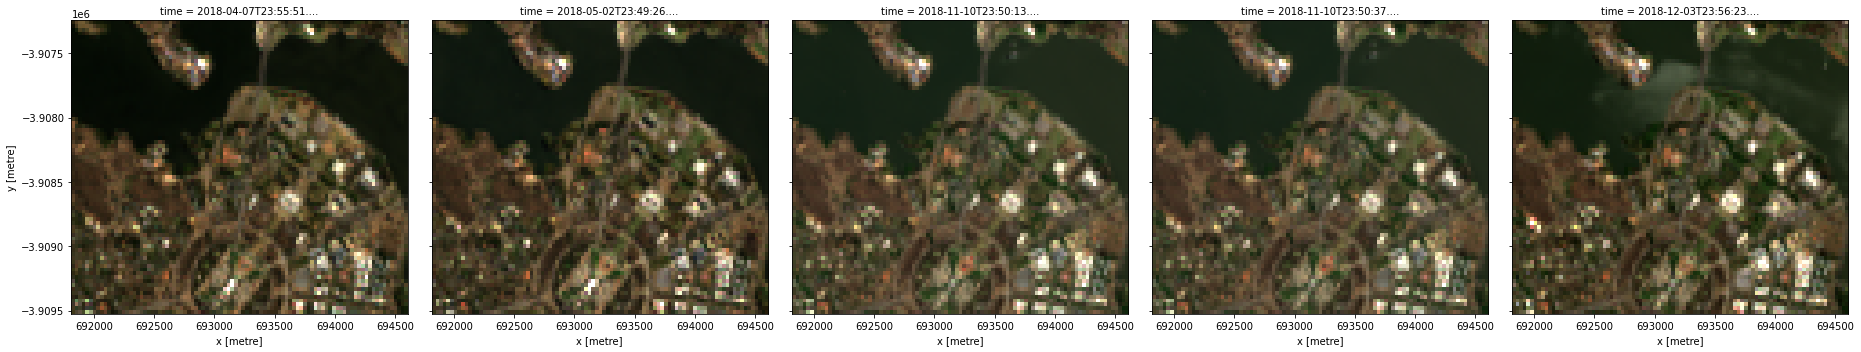

In [140]:
rgb_30m.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

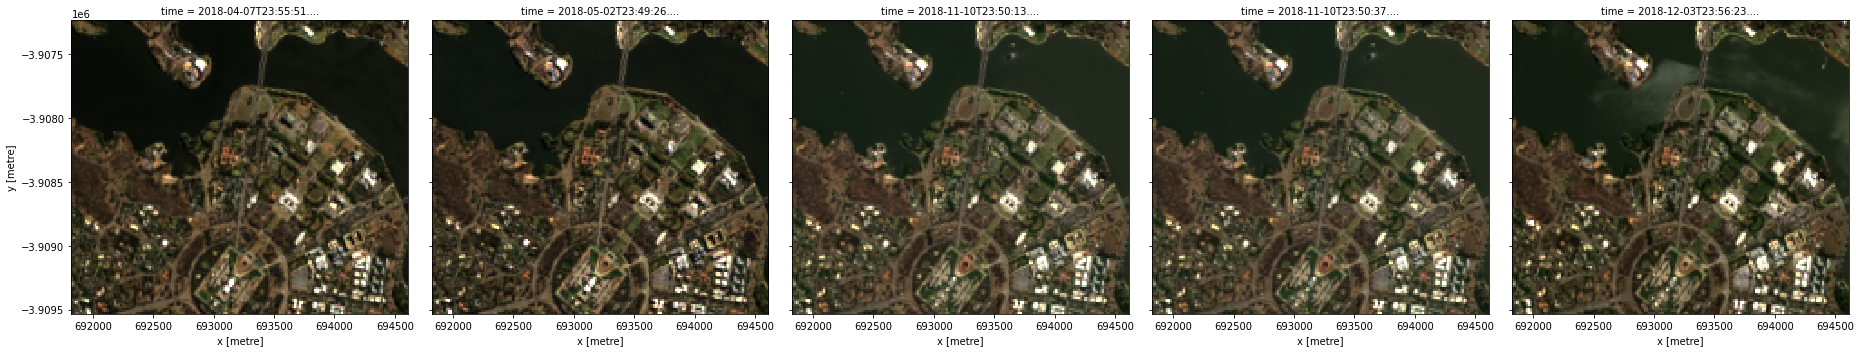

In [141]:
ds_pansharpened_hsv = pansharpen_hsv(ds=rgbp_15m)
ds_pansharpened_hsv.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

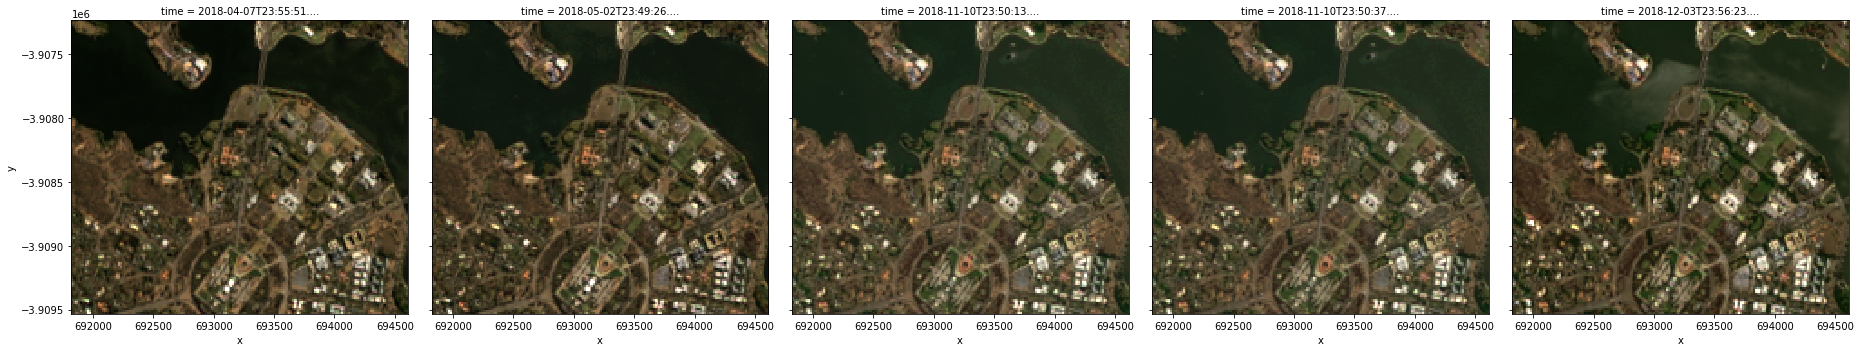

In [142]:
ds_pansharpened_brovey = pansharpen_brovey(ds=rgbp_15m)
ds_pansharpened_brovey.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

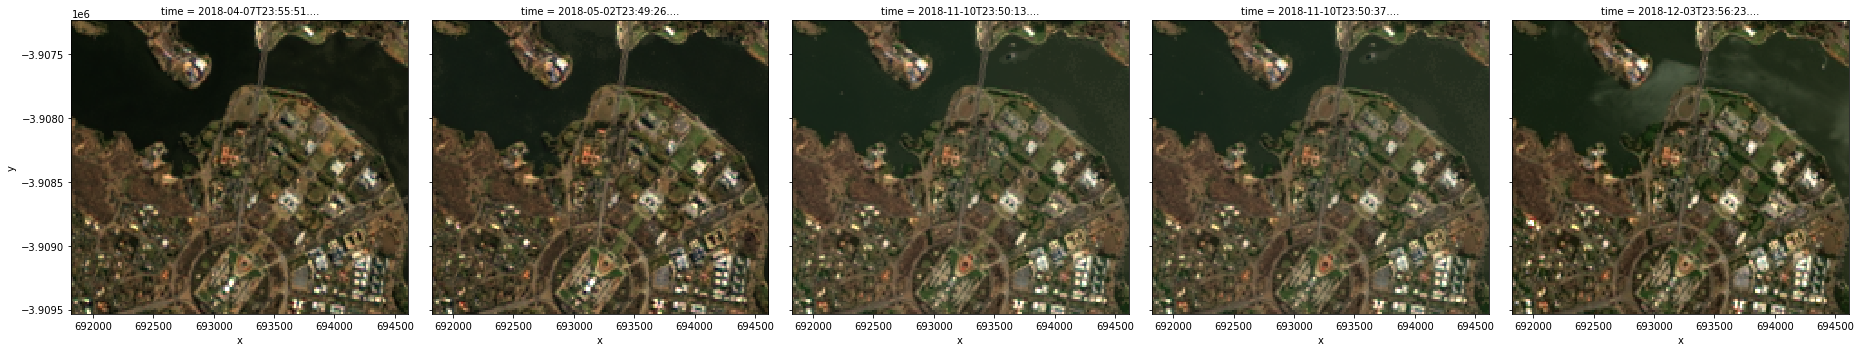

In [143]:
ds_pansharpened_pca = pansharpen_pca(ds=rgbp_15m)
ds_pansharpened_pca.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

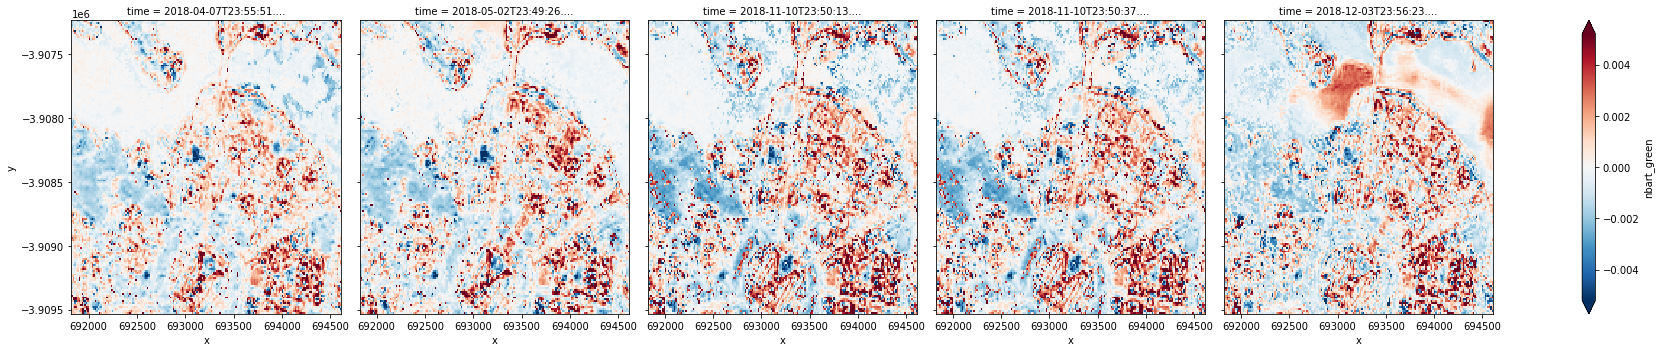

In [145]:
(((ds_pansharpened_pca - ds_pansharpened_brovey).nbart_green) / 10000.0 ).plot(col='time', col_wrap=5, robust=True, size=5)

In [146]:
xr_pansharpen(ds=rgbp_15m, method='hsv', output_dtype=np.uint16, return_pan=True)

<xarray.Dataset>
Dimensions:             (time: 5, y: 153, x: 186)
Coordinates:
  * time                (time) datetime64[ns] 2018-04-07T23:55:51.859370 ... ...
  * y                   (y) float64 -3.907e+06 -3.907e+06 ... -3.91e+06
  * x                   (x) float64 6.918e+05 6.918e+05 ... 6.946e+05 6.946e+05
    spatial_ref         int32 32655
Data variables:
    nbart_red           (time, y, x) uint16 559 662 604 734 ... 362 298 218 208
    nbart_green         (time, y, x) uint16 527 587 514 601 ... 402 356 282 299
    nbart_blue          (time, y, x) uint16 304 360 329 377 ... 241 199 147 145
    nbart_panchromatic  (time, y, x) uint16 559 662 604 734 ... 402 356 282 299
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref